In [1]:
import yfinance
import numpy as np
import os
import pandas as pd
import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [2]:
path ='C:/project/전력'
file_list = os.listdir(path)
# 텍스트 파일만 추출
file_list_txt = [file for file in file_list if file.endswith('txt')]
date = []
power = []
count = 0
for i in range(len(file_list_txt)):
    
    file = open(file_list_txt[i]).read().splitlines()
    del file[:2]
    if (len(file) == 24):
        
        data_clean = []
        daily_date = []
        daily_power = []
        for j in range(len(file)):
            line = file[j].split(sep=' ')
            data_clean.append(line)
            daily_date.append(data_clean[j][0]+' '+data_clean[j][1])
            daily_power.append(data_clean[j][-1])
        for k in range(len(daily_power)):
            daily_power[k] = daily_power[k].replace(")","")
            daily_power[k] = int(daily_power[k])
        date.append(daily_date)
        power.append(daily_power)
    else:
        pass
date = sum(date, [])
power = sum(power, [])

# # 판다스로 변환
# edf_col_name = ['date', 0]
# edf = pd.DataFrame([x for x in zip(date, power)], columns = edf_col_name)
# # 날짜 컬럼으로 인덱스 대체하기
# edf = edf.set_index("date")
# edf[0]=edf[0].apply(float)

date = np.array(date)
power = np.array(power)


In [3]:
date.shape, power.shape

((37296,), (37296,))

In [4]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(16, 8))
# plt.plot(date, power)
# plt.xlabel("Date")
# plt.ylabel("Power")
# plt.grid(True)

In [5]:
split_time = 30000

date_train = date[:split_time]
date_valid = date[split_time:]

x_train = power[:split_time]
x_valid = power[split_time:]

In [19]:
window_size=24
batch_size = 50
shuffle_size = 1000

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
train_set = windowed_dataset(x_train, 
                             window_size=window_size, 
                             batch_size=batch_size,
                             shuffle_buffer=shuffle_size)

validation_set = windowed_dataset(x_valid, 
                                  window_size=window_size,
                                  batch_size=batch_size,
                                  shuffle_buffer=shuffle_size)

In [22]:
from tensorflow.keras.layers import Dense, LSTM, Lambda, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
model = Sequential([
    tf.keras.layers.Conv1D(256, kernel_size=5,
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 256)         1536      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)               

In [25]:
optimizer = Adam(0.0005)

In [26]:
loss= Huber()

In [27]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=["mse"])

In [28]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_path = 'tmp_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_mae',
                             verbose=1)

In [29]:
epochs=100

In [30]:
history = model.fit(train_set, 
                    validation_data=(validation_set), 
                    epochs=epochs, 
                    callbacks=[checkpoint, earlystopping],
                   )

Epoch 1/100
    600/Unknown - 12s 19ms/step - loss: 939.6962 - mse: 2156812.5000WARNING:tensorflow:Can save best model only with val_mae available, skipping.
600/600 [==============================] - 14s 23ms/step - loss: 939.6962 - mse: 2156812.5000 - val_loss: 891.1445 - val_mse: 2087744.7500
Epoch 2/100
600/600 [==============================] - 12s 19ms/step - loss: 927.6652 - mse: 2093649.6250 - val_loss: 888.8188 - val_mse: 2062912.1250
Epoch 3/100
600/600 [==============================] - 11s 19ms/step - loss: 926.0977 - mse: 2086434.0000 - val_loss: 887.4675 - val_mse: 2038243.5000
Epoch 4/100
600/600 [==============================] - 13s 21ms/step - loss: 926.2493 - mse: 2089755.0000 - val_loss: 888.5632 - val_mse: 2076080.7500
Epoch 5/100
600/600 [==============================] - 15s 25ms/step - loss: 925.9031 - mse: 2084124.3750 - val_loss: 886.6865 - val_mse: 1994819.2500
Epoch 6/100
600/600 [==============================] - 12s 20ms/step - loss: 925.8229 - mse: 208390

Epoch 27/100
600/600 [==============================] - 11s 19ms/step - loss: 919.8281 - mse: 2085553.0000 - val_loss: 882.1591 - val_mse: 1995746.6250
Epoch 28/100
600/600 [==============================] - 13s 22ms/step - loss: 919.7416 - mse: 2084417.3750 - val_loss: 881.6668 - val_mse: 2006504.6250
Epoch 29/100
600/600 [==============================] - 15s 25ms/step - loss: 919.5096 - mse: 2084690.5000 - val_loss: 881.3136 - val_mse: 1996301.6250
Epoch 30/100
600/600 [==============================] - 13s 22ms/step - loss: 919.4959 - mse: 2084053.6250 - val_loss: 881.5270 - val_mse: 2024506.2500
Epoch 31/100
600/600 [==============================] - 13s 22ms/step - loss: 919.3311 - mse: 2084149.6250 - val_loss: 881.2587 - val_mse: 2008134.8750
Epoch 32/100
600/600 [==============================] - 12s 20ms/step - loss: 919.2744 - mse: 2083857.8750 - val_loss: 881.3480 - val_mse: 1991458.3750
Epoch 33/100
600/600 [==============================] - 13s 22ms/step - loss: 919.1784 -

Epoch 53/100
600/600 [==============================] - 11s 19ms/step - loss: 918.3740 - mse: 2085868.8750 - val_loss: 880.2675 - val_mse: 1988810.2500
Epoch 54/100
600/600 [==============================] - 12s 19ms/step - loss: 918.3297 - mse: 2086616.7500 - val_loss: 880.3639 - val_mse: 1982836.8750
Epoch 55/100
600/600 [==============================] - 11s 19ms/step - loss: 918.3058 - mse: 2086533.8750 - val_loss: 880.2184 - val_mse: 2012597.6250
Epoch 56/100
600/600 [==============================] - 12s 19ms/step - loss: 918.3191 - mse: 2086514.7500 - val_loss: 880.3467 - val_mse: 1983295.1250
Epoch 57/100
600/600 [==============================] - 12s 19ms/step - loss: 918.2886 - mse: 2086228.0000 - val_loss: 880.3866 - val_mse: 1980004.5000
Epoch 58/100
600/600 [==============================] - 12s 19ms/step - loss: 918.2674 - mse: 2086133.1250 - val_loss: 880.1532 - val_mse: 1997293.8750
Epoch 59/100
600/600 [==============================] - 12s 20ms/step - loss: 918.2221 -

In [37]:
model.load_weights(checkpoint_path)

ValueError: Shapes (256,) and (60,) are incompatible

In [33]:
import matplotlib.pyplot as plt
pred = model.predict(validation_set)
print(pred)

[[295.2426 ]
 [583.58466]
 [629.70355]
 ...
 [532.05225]
 [271.2107 ]
 [550.1671 ]]


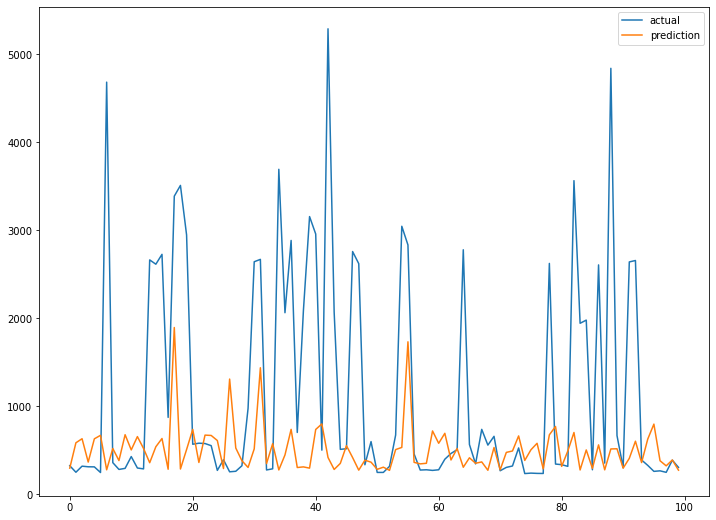

In [39]:
plt.figure(figsize=(12, 9))
plt.plot(x_valid[:100], label='actual')
plt.plot(pred[:100], label='prediction')
plt.legend()
plt.show()